2017-08-22 12:45:01.846000
Now Plotting Errors
Processed image 0 of 1593
Processed image 1 of 1593
Processed image 2 of 1593
Processed image 3 of 1593
Processed image 4 of 1593
Processed image 5 of 1593
Processed image 6 of 1593
Processed image 7 of 1593
Processed image 8 of 1593
Processed image 9 of 1593
Processed image 10 of 1593
Processed image 11 of 1593
Processed image 12 of 1593
Processed image 13 of 1593
Processed image 14 of 1593
Processed image 15 of 1593
Processed image 16 of 1593
Processed image 17 of 1593
Processed image 18 of 1593
Processed image 19 of 1593
Processed image 20 of 1593
Processed image 21 of 1593
Processed image 22 of 1593
Processed image 23 of 1593
Processed image 24 of 1593
Processed image 25 of 1593
Processed image 26 of 1593
Processed image 27 of 1593
Processed image 28 of 1593
Processed image 29 of 1593
Processed image 30 of 1593
Processed image 31 of 1593
Processed image 32 of 1593
Processed image 33 of 1593
Processed image 34 of 1593
Processed image 35

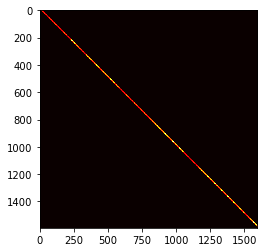

Plot Saved to Disk


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import similaritymetrics as ims
import datetime
import math
from scipy.sparse import dia_matrix

def plotError(frameCount, extraDiag):
    print "Now plotting errors"
    #Create our array of zeros as a 2D numpy array
    errors = np.zeros((frameCount, frameCount))
    #Now Populate our 2 Diagonal Errors
    #Current structure allows image0 loaded once and reused
    for i in range(0, frameCount):
        image1 = cv2.imread("C:\\Users\\Alex\\Documents\\Dissertation\\cleanedTimeLapseFrame\\frame%0*d.jpg" %(4,i))
        image2 = cv2.imread("C:\\Users\\Alex\\Documents\\Dissertation\\cleanedTimeLapseFrame\\frame%0*d.jpg" %(4,i+1))
        #First Diagonal is y=x+1
        errors[i, i+1]=ims.dssimCompare(image1, image2)
        #Second Diagonal is y=x+2
        #This loop calls our extra diagonals for however many we specify
        #We need to add guarding here to prevent looking for an image that extends beyond available frames
        for j in range(0, extraDiag):
            image2 = cv2.imread("C:\\Users\\Alex\\Documents\\Dissertation\\cleanedTimeLapseFrame\\frame%0*d.jpg" %(4,i+3+j))
            #null pointer type exception
            if(image2 is None):
                continue
            errors[i, i+2+j]=ims.dssimCompare(image1, image2)    
    #Save our array
    np.savetxt('arrayneuss.txt', errors)
    print "Array saved to disk"
    #Now plot and we need a way to save our plot
    plt.imshow(errors, cmap='hot', interpolation='nearest')
    plt.show()
    plt.savefig("errorplot.png")
    print "Plot Saved to Disk"
    
def plotErrorDict(frameCount, extraDiag):
    print "Now Plotting Errors"
    errors = np.zeros((frameCount, frameCount))
    #errorsSparse = dia_matrix((frameCount, frameCount))
    #Create Dictionary with initial items
    imagedict = {}
    for i in range(0, frameCount):
        #Add Entries to Dictionary, only add a single entry when i>1
        if(i>0):
            imagedict["{0}".format(i+extraDiag+1)]= cv2.imread("C:\\Users\\Alex\\Documents\\Dissertation\\cleanedTimeLapseFrame\\image%0*d.jpg" %(4,i+extraDiag+1))
        else:
            for j in range(i, extraDiag+2):   
                imagedict["{0}".format(j)]= cv2.imread("C:\\Users\\Alex\\Documents\\Dissertation\\cleanedTimeLapseFrame\\image%0*d.jpg" %(4,j))
        #Then Compare
        for k in range(i+1, i+extraDiag+2):
            if(imagedict["%d" %(k)] is None):
                continue
            if(i<frameCount and k<frameCount):
                errors[i,k] = ims.dssimCompare(imagedict["%d" %(i)],imagedict["%d" %(k)])
        #Then delete as needed, we'll delete the earliest created entry
        del imagedict["%d" %(i)]
        print ("Processed image %d of %d" %(i, frameCount-1))
    np.savetxt('swiss_dssim.txt', errors)
    #np.savetxt('sparsearray.txt', errorsSparse)
    print "Array saved to disk"
    #Now plot and we need a way to save our plot
    plt.imshow(errors, cmap='hot', interpolation='nearest')
    plt.show()
    plt.savefig("errorplot.png")
    print "Plot Saved to Disk"
    
#Main Function
#By this unscientific timing the first algo takes 24 seconds and the dictionary based approach is 16 seconds. So roughly 33% quicker
#Repeated with dSSIM we have 7min 6sec and 6min 42 sec. Likely due to the fact that the increase is due to dSSIM being more costly
print datetime.datetime.utcnow()
plotErrorDict(1594, 15)
